<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/CodechallengeWeights_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [3]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


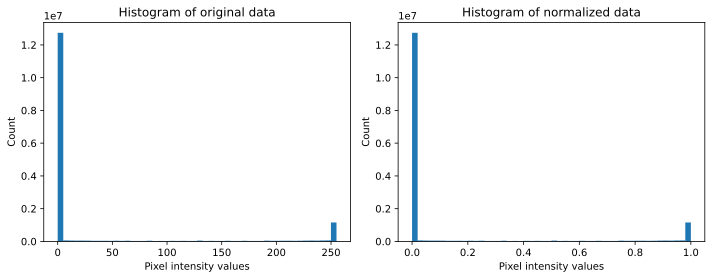

In [4]:
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Create train/TEST GROUPS USING DataLoader

In [5]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Create the DL model

In [6]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Create a function that trains the model

In [7]:
# a function that trains the model
def function2trainTheModel(net,lossfun,optimizer):
  #number of epocs
  numepochs=10
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

Start the experiment!!!

In [11]:
stdevs=np.logspace(np.log10(.0001),np.log10(10),25)
#number of histogram bins for plotting distributions

nhistBins=80
#initialize results output matrix
accresults=np.zeros(len(stdevs))
histodata=np.zeros((len(stdevs),2,nhistBins))
#start the timer!
startTime=time.process_time()
#now to really start the experiment
for idx,std in enumerate(stdevs):
  #change the weights before training
  net,lossfun,optimizer=createTheMNISTNet()
  #set all parameters according to the standard deviation
  for p in net.named_parameters():
    p[1].data=torch.randn_like(p[1].data)*std
  #train the model
  trainAcc,testAcc,losses,net=function2trainTheModel(net,lossfun,optimizer)
  #get test accuracy on final 3 runs(averaging increases stability)
  accresults[idx]=np.mean(testAcc[-3:])
  #collect all parameters into one vector and compute its histogram
  tmpparams=np.array([])
  for p in net.named_parameters():
    tmpparams=np.concatenate((tmpparams,p[1].data.numpy().flatten()),axis=0)
  #now compute their histogram
  y,x=np.histogram(tmpparams,nhistBins)
  histodata[idx,0,:]=(x[1:]+x[:-1])/2
  histodata[idx,1,:]=y
  #status report
  timeElapsed=time.process_time()-startTime
  print(f'Finished {idx+1}/{len(stdevs)} after {timeElapsed:3.0f}s.Model accuracy was{accresults[idx]:.2f}%')



Finished 1/25 after  20s.Model accuracy was92.62%
Finished 2/25 after  42s.Model accuracy was95.25%
Finished 3/25 after  63s.Model accuracy was93.63%
Finished 4/25 after  85s.Model accuracy was10.67%
Finished 5/25 after 106s.Model accuracy was93.20%
Finished 6/25 after 125s.Model accuracy was94.18%
Finished 7/25 after 146s.Model accuracy was93.62%
Finished 8/25 after 167s.Model accuracy was94.23%
Finished 9/25 after 185s.Model accuracy was93.85%
Finished 10/25 after 205s.Model accuracy was92.98%
Finished 11/25 after 223s.Model accuracy was94.58%
Finished 12/25 after 242s.Model accuracy was94.50%
Finished 13/25 after 259s.Model accuracy was95.17%
Finished 14/25 after 278s.Model accuracy was95.18%
Finished 15/25 after 298s.Model accuracy was94.27%
Finished 16/25 after 316s.Model accuracy was94.93%
Finished 17/25 after 333s.Model accuracy was95.03%
Finished 18/25 after 350s.Model accuracy was94.92%
Finished 19/25 after 368s.Model accuracy was93.28%
Finished 20/25 after 387s.Model accuracy

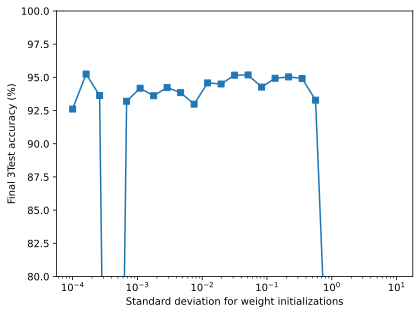

In [12]:
#show the results
plt.plot(stdevs,accresults,'s-')
plt.xscale('log')
plt.xlabel('Standard deviation for weight initializations')
plt.ylabel('Final 3Test accuracy (%)')
plt.ylim([80,100])
plt.show()

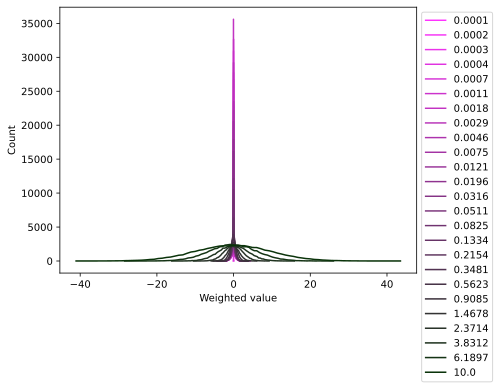

In [13]:
#show the weights distributions
for i in range(len(stdevs)):
  plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])
plt.xlabel('Weighted value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),bbox_to_anchor=(1,1),loc='upper left')
plt.show()